In [1]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import os

In [3]:
# Constants
IMAGE_SIZE_1 = 225
IMAGE_SIZE_2 = 225
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
NUM_CLASSES = 27  # Adjust this based on your dataset
DATASET_PATH = "/content/drive/MyDrive/PharmaScope"

In [4]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE_1, IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

Found 3495 files belonging to 27 classes.


In [5]:
# Get class names
class_names = dataset.class_names

In [6]:
# Split dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
# Cache, shuffle, and prefetch the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
import tensorflow as tf

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [10]:
inception = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE_1, IMAGE_SIZE_2, 3)
)

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
# Freeze the InceptionV3 layers
for layer in inception.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [12]:
# Build the model with the correct input shape
model.build(input_shape=(None, IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS))

In [13]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                                 
Total params: 22865723 (87.23 MB)
Trainable params: 1062939 (4.05 MB)
Non-trainable params: 21802784 (83.17 MB)
________

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
88/88 [==============================] - 408s 2s/step - loss: 5.8391 - accuracy: 0.2931 - val_loss: 1.5661 - val_accuracy: 0.6449
Epoch 2/50
88/88 [==============================] - 3s 32ms/step - loss: 1.6905 - accuracy: 0.4869 - val_loss: 0.8956 - val_accuracy: 0.8210
Epoch 3/50
88/88 [==============================] - 3s 33ms/step - loss: 1.3602 - accuracy: 0.5855 - val_loss: 0.7252 - val_accuracy: 0.8523
Epoch 4/50
88/88 [==============================] - 3s 33ms/step - loss: 1.1638 - accuracy: 0.6378 - val_loss: 0.5545 - val_accuracy: 0.8580
Epoch 5/50
88/88 [==============================] - 3s 32ms/step - loss: 0.9785 - accuracy: 0.6904 - val_loss: 0.4084 - val_accuracy: 0.9148
Epoch 6/50
88/88 [==============================] - 3s 33ms/step - loss: 0.8773 - accuracy: 0.7094 - val_loss: 0.3248 - val_accuracy: 0.9205
Epoch 7/50
88/88 [==============================] - 3s 32ms/step - loss: 0.7730 - accuracy: 0.7410 - val_loss: 0.3130 - val_accuracy: 0.9233
Epoch 8/50
88

In [16]:
# Evaluate the model
scores = model.evaluate(test_ds)
print(f'Test Accuracy: {scores[1]}')

11/11 [==============================] - 173s 29ms/step - loss: 0.0473 - accuracy: 1.0000
Test Accuracy: 1.0


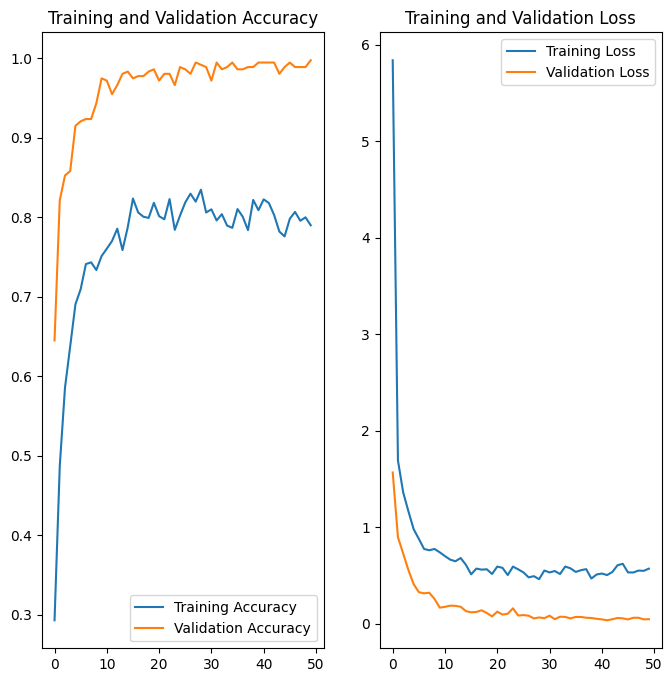

In [17]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Make predictions
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    preds = model.predict(images_batch)
    y_pred.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 33ms/step


In [19]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10

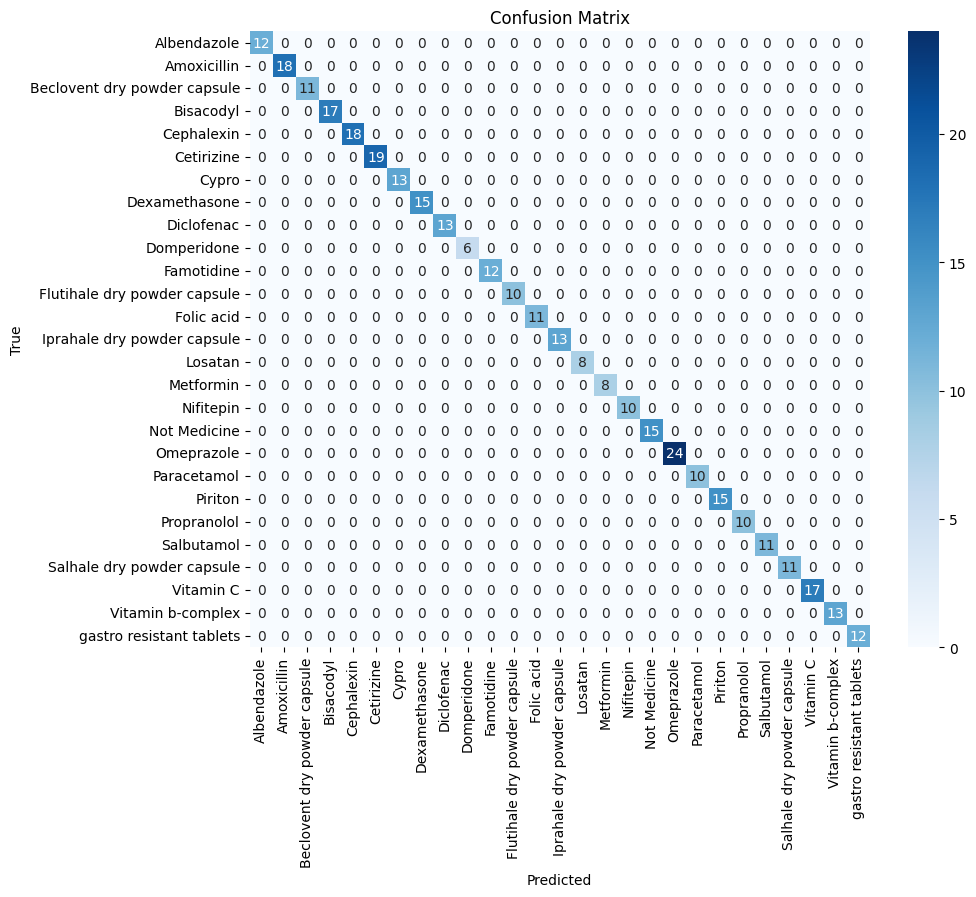

In [20]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Classification report
cr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(cr)

Classification Report
                              precision    recall  f1-score   support

                 Albendazole       1.00      1.00      1.00        12
                 Amoxicillin       1.00      1.00      1.00        18
Beclovent dry powder capsule       1.00      1.00      1.00        11
                   Bisacodyl       1.00      1.00      1.00        17
                  Cephalexin       1.00      1.00      1.00        18
                  Cetirizine       1.00      1.00      1.00        19
                       Cypro       1.00      1.00      1.00        13
               Dexamethasone       1.00      1.00      1.00        15
                  Diclofenac       1.00      1.00      1.00        13
                 Domperidone       1.00      1.00      1.00         6
                  Famotidine       1.00      1.00      1.00        12
Flutihale dry powder capsule       1.00      1.00      1.00        10
                  Folic acid       1.00      1.00      1.00        

In [22]:
# Precision, recall, F1 score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Accuracy: {accuracy}')

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0


In [23]:

model.save(f"/content/drive/MyDrive/CorrectOnes/Inception.h5") # Add .keras extension

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
